In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from matplotlib import pyplot as plt
import pandas as pd
import random
import os
import numpy as np
import cv2

In [2]:
text_prompts = {1: 'network of fine, hairline cracks or fissures on the surface of the steel',
                2: 'scale—oxides embedded into the steel plate',
                3: 'shallow, narrow grooves or lines on the surface of the steel',
                4: 'impurity or foreign material embedded within the steel matrix'}

In [3]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()

    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths

    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T

In [4]:
def padding_image(img, new_image_width, new_image_height):

    old_image_height, old_image_width, channels = img.shape
    
    # create new image of desired size and color (blue) for padding

    color = (0,0,0)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    
    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
           x_center:x_center+old_image_width] = img
    
    return result
    
   

In [5]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/home/eas/miniconda3/envs/clipseg/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
target_class = 4
defects_path = f'/home/eas/Enol/pycharm_projects/clipseg_steel_defect/Severstal/cropped_defects/{target_class}'
images_path = '/home/eas/Enol/pycharm_projects/clipseg_steel_defect/Severstal/train_images'
df = pd.read_csv('/home/eas/Enol/pycharm_projects/clipseg_steel_defect/Severstal/train.csv')
df = df[df['ClassId'] == target_class]
length = len(df)
idx = random.randint(0,length-1)
image_name = df[['ImageId']].iloc[idx,0]
image = cv2.imread(f'{images_path}/{image_name}')
defects = os.listdir(defects_path)
defect = cv2.imread(f'{defects_path}/{defects[random.randint(0,len(defects)-1)]}')
while defect.shape[1] > 352:
    defect = cv2.imread(f'{defects_path}/{defects[random.randint(0,len(defects)-1)]}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
defect = cv2.cvtColor(defect, cv2.COLOR_BGR2RGB)
defect = padding_image(defect, 352, 352)
img_bounded = image.copy()
image = padding_image(image, 1760, 352)

height = 1600
width = 256
mk = rle_decode(df.iloc[idx]['EncodedPixels'], (height, width))
contours, hierarchy = cv2.findContours(mk,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
for i, contour in enumerate(contours):
    cv2.drawContours(img_bounded, contour, -1, (0, 0, 255), 2)

img_bounded = padding_image(img_bounded, 1760, 352)

imgheight=image.shape[0]
imgwidth=image.shape[1]
M = imgheight//1
N = imgwidth//5
blocks = []
blocks_bounded = []
for y in range(0,imgheight,M):
    for x in range(0, imgwidth, N):
        tiles = image[y:y+M,x:x+N, :]
        blocks.append(tiles)
        tiles = img_bounded[y:y+M,x:x+N, :]
        blocks_bounded.append(tiles)



In [7]:
only_text = False

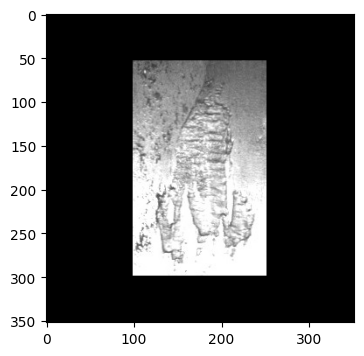

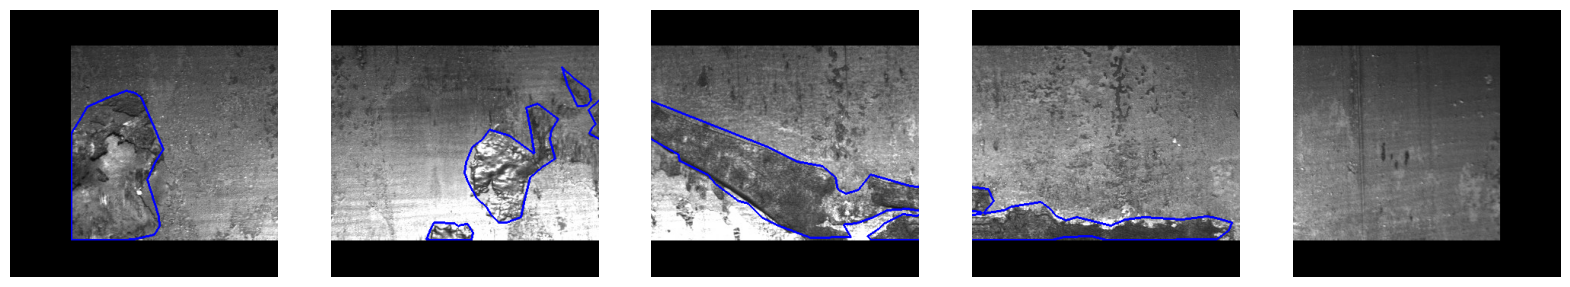

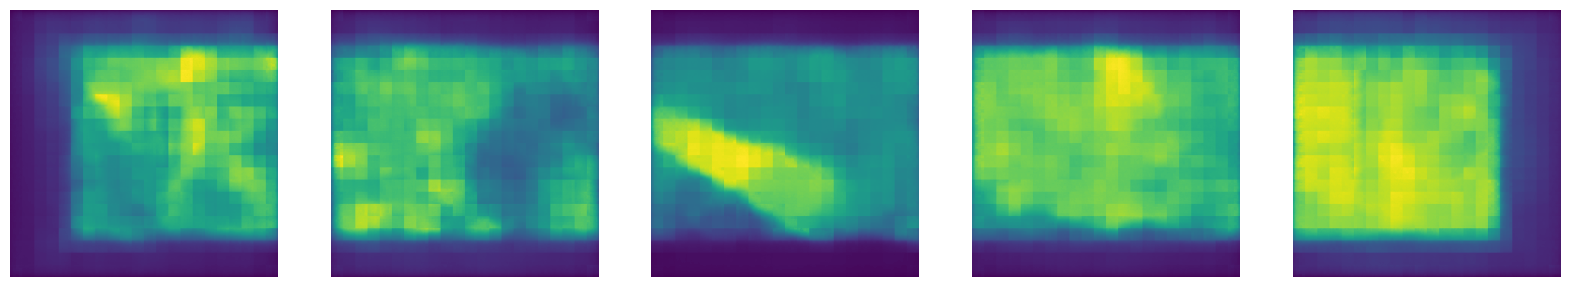

In [8]:
import torch
# predict
encoded_reference = processor(images=[defect], return_tensors='pt')
results = []
for i, block in enumerate(blocks):
    encoded_image = processor(text=[text_prompts[target_class]], images=[block], return_tensors='pt')

    with torch.no_grad():
        if only_text:
            outputs = model(**encoded_image)
        else:
            outputs = model(**encoded_image, conditional_pixel_values = encoded_reference.pixel_values)

    preds = outputs.logits.unsqueeze(1)
    preds = torch.transpose(preds, 0, 1).squeeze(0)
    results.append(torch.sigmoid(preds[0]))
    
_, ax = plt.subplots(1,1, figsize=(4, 4))
ax.imshow(defect)

_, ax = plt.subplots(1, 5, figsize=(20, 10))
[a.axis('off') for a in ax.flatten()]
[ax[i].imshow(blocks_bounded[i]) for i in range(5)]

_, ax = plt.subplots(1, 5, figsize=(20, 8))
[a.axis('off') for a in ax.flatten()]
[ax[i].imshow(results[i]) for i in range(5)]






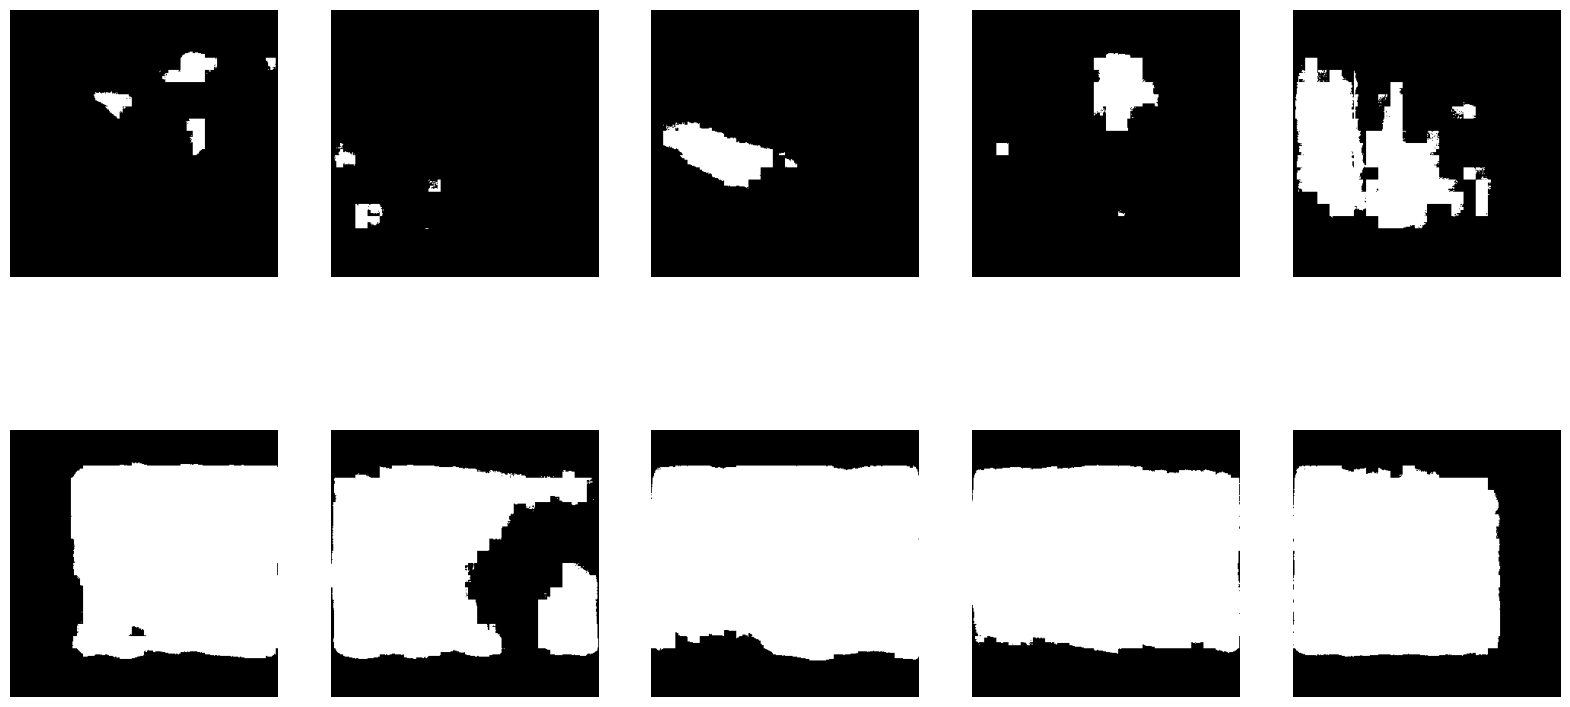

In [9]:

filenames = [f"mask_{i}.png" for i in range(5)]
result_masks = []
_, ax = plt.subplots(2, 5, figsize=(20, 10))
[a.axis('off') for a in ax.flatten()]
# here we save the second mask
for i, filename in enumerate(filenames):  
    plt.imsave(filename,results[i])
    img = cv2.imread(filename)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, result_mask) = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
    _, binary_map_otsu = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    result_masks.append(result_mask)
    ax[0, i].imshow(result_mask, cmap='gray')
    ax[1, i].imshow(binary_map_otsu, cmap='gray')

In [10]:
torch.mean(results[2])

tensor(0.2345)

In [11]:
'''
results_path = f'/home/eas/Enol/clipseg/severstal-steel-defect-detection/results/{target_class}'
dir_name = image_name[0:9]
path = os.path.join(results_path, dir_name)
if not os.path.exists(path):
    os.mkdir(path)

plt.imsave(f'{path}/defect.png',defect)

for i, block in enumerate(blocks_bounded):
    plt.imsave(f'{path}/image_block_{i}.png', block)

for i, result in enumerate(results):
    plt.imsave(f'{path}/heatmap_{i}.png', result)
    
for i, mask in enumerate(result_masks):
    plt.imsave(f'{path}/result_mask_{i}.png', mask)
    
'''

"\nresults_path = f'/home/eas/Enol/clipseg/severstal-steel-defect-detection/results/{target_class}'\ndir_name = image_name[0:9]\npath = os.path.join(results_path, dir_name)\nif not os.path.exists(path):\n    os.mkdir(path)\n\nplt.imsave(f'{path}/defect.png',defect)\n\nfor i, block in enumerate(blocks_bounded):\n    plt.imsave(f'{path}/image_block_{i}.png', block)\n\nfor i, result in enumerate(results):\n    plt.imsave(f'{path}/heatmap_{i}.png', result)\n    \nfor i, mask in enumerate(result_masks):\n    plt.imsave(f'{path}/result_mask_{i}.png', mask)\n    \n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


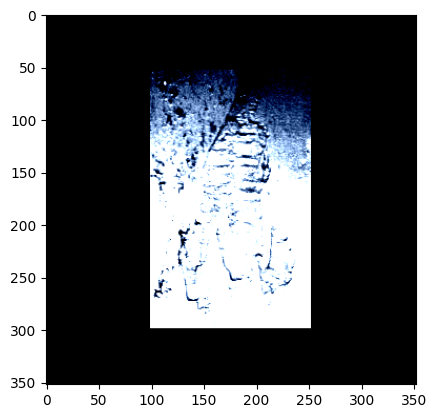

In [20]:
plt.imshow(encoded_reference.pixel_values.squeeze(0).permute(1,2,0).numpy())